In [213]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
plt.style.use('bmh')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
from IPython.core.display import display, HTML
pylab.rcParams.update(params)
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler

In [214]:
df = pd.read_csv("y_hat_final.csv")
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df.shape
df.rename(columns={"y":"Close"},inplace=True)

In [215]:
df["tmp"] = df.Close - df.y_hat

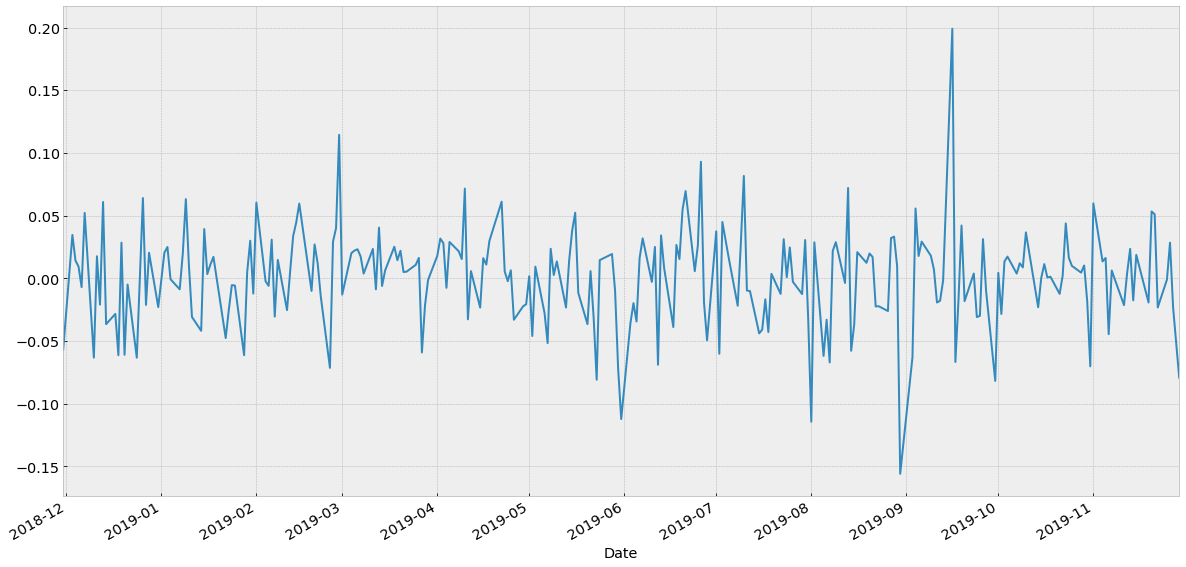

In [216]:
df.tmp.plot()

In [217]:
# import talib
# talib.RSI(df.Close)
#RSI + MA + ENSEMBLE

In [218]:
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals["y_hat"] = df.y_hat
signals["y"] = df.Close

In [219]:
signals["y_tmp"] = signals.y.shift()
signals.fillna(0, inplace=True)

In [220]:
signals.head()

,signal,y_hat,y,y_tmp
Date,,,,
2018-11-30,0.0,1.453961,1.3973,0.0000
2018-12-03,0.0,1.396895,1.4315,1.3973
2018-12-04,0.0,1.428154,1.4423,1.4315
2018-12-05,0.0,1.439226,1.4486,1.4423
2018-12-06,0.0,1.444650,1.4376,1.4486


In [221]:
signals["e_rr"] = (signals.y_hat-signals.y_tmp)/(signals.y_tmp)*100
signals["true_rr"] = (signals.y-signals.y_tmp)/(signals.y_tmp)*100

In [222]:
signals.head()

,signal,y_hat,y,y_tmp,e_rr,true_rr
Date,,,,,,
2018-11-30,0.0,1.453961,1.3973,0.0000,inf,inf
2018-12-03,0.0,1.396895,1.4315,1.3973,-0.028977,2.447577
2018-12-04,0.0,1.428154,1.4423,1.4315,-0.233718,0.754453
2018-12-05,0.0,1.439226,1.4486,1.4423,-0.213121,0.436802
2018-12-06,0.0,1.444650,1.4376,1.4486,-0.272693,-0.759354


In [223]:
signals = signals[["signal",'e_rr',"true_rr"]]

In [224]:
signals["e_rr"][0] = 0

In [225]:
signals.signal = np.where(signals['e_rr']>0.2, 1, np.where(signals['e_rr']<-0.2, -1, 0))

In [226]:
signals.signal.value_counts()

 0    182
-1     37
 1     33
Name: signal, dtype: int64

In [227]:
signals["num"] = [x for x in (range(len(signals.index)))]

In [228]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1000,
    max_sell = 1000
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    try:
        adj = (current_inventory*real_movement[-1])
    except:
        adj = 0
            
    invest = ((initial_money + adj - starting_money) / starting_money) * 100
    total_gains = initial_money + adj - starting_money
    return states_buy, states_sell, total_gains, invest

In [229]:
# states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])
states_buy, states_sell, total_gains, invest = buy_stock(df.Close.shift(1).bfill(), signals['signal'])

day 2: cannot sell anything, inventory 0
day 3: cannot sell anything, inventory 0
day 4: cannot sell anything, inventory 0
day 6: cannot sell anything, inventory 0
day 10: cannot sell anything, inventory 0
day 13: buy 1000 units at price 1351.100000, total balance 8648.900000
day 15: buy 1000 units at price 1322.400000, total balance 7326.500000
day 17: buy 1000 units at price 1259.500000, total balance 6067.000000
day 18, sell 1000 units at price 1329.000000, investment 5.518063 %, total balance 7396.000000,
day 27, sell 1000 units at price 1425.100000, investment 13.148075 %, total balance 8821.100000,
day 29: buy 1000 units at price 1401.600000, total balance 7419.500000
day 30: buy 1000 units at price 1364.000000, total balance 6055.500000
day 35: buy 1000 units at price 1403.800000, total balance 4651.700000
day 36: buy 1000 units at price 1386.300000, total balance 3265.400000
day 37: buy 1000 units at price 1388.400000, total balance 1877.000000
day 38: buy 1000 units at price 1

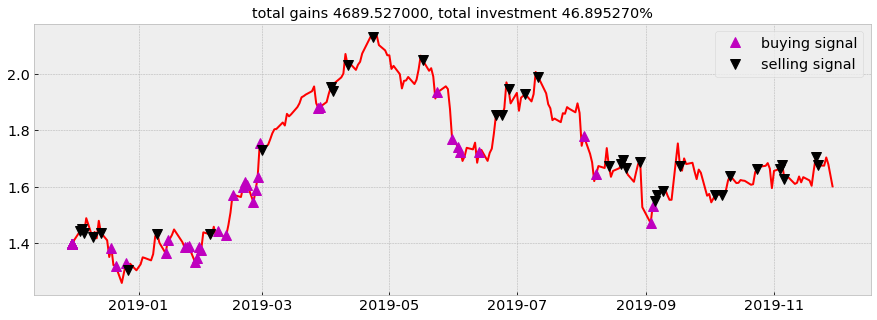

In [230]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()